In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
%matplotlib inline

In [3]:
#Download full dataset for US location key. A list of location keys can be found in ../data/index.csv
data_key = "US"
df = pd.read_csv(f'https://storage.googleapis.com/covid19-open-data/v3/location/{data_key}.csv', parse_dates=["date"], index_col="date")
df.shape

(540, 526)

In [16]:
#There are 526 features. Details for ech can be found in Google Open COVID-19 Data repository. For now, subset ones we are interested in.
mobility = ["mobility_retail_and_recreation", "mobility_grocery_and_pharmacy", "mobility_parks", "mobility_transit_stations", "mobility_workplaces", "mobility_residential"]
restrictions = ["school_closing", "workplace_closing", "cancel_public_events","restrictions_on_gatherings", "public_transport_closing", "stay_at_home_requirements", "restrictions_on_internal_movement", "stringency_index"]
virus = ["new_confirmed", "cumulative_persons_fully_vaccinated"]
df=df[mobility+restrictions+virus]

In [34]:
#See how many null values there are for each variable. These will have to be cleaned/interpolated later
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 540 entries, 2020-01-01 to 2021-06-23
Data columns (total 16 columns):
mobility_retail_and_recreation         490 non-null float64
mobility_grocery_and_pharmacy          490 non-null float64
mobility_parks                         490 non-null float64
mobility_transit_stations              490 non-null float64
mobility_workplaces                    490 non-null float64
mobility_residential                   490 non-null float64
school_closing                         530 non-null float64
workplace_closing                      530 non-null float64
cancel_public_events                   530 non-null float64
restrictions_on_gatherings             530 non-null float64
public_transport_closing               530 non-null float64
stay_at_home_requirements              530 non-null float64
restrictions_on_internal_movement      530 non-null float64
stringency_index                       530 non-null float64
new_confirmed                       

mobility_retail_and_recreation          50
mobility_grocery_and_pharmacy           50
mobility_parks                          50
mobility_transit_stations               50
mobility_workplaces                     50
mobility_residential                    50
school_closing                          10
workplace_closing                       10
cancel_public_events                    10
restrictions_on_gatherings              10
public_transport_closing                10
stay_at_home_requirements               10
restrictions_on_internal_movement       10
stringency_index                        10
new_confirmed                            4
cumulative_persons_fully_vaccinated    348
dtype: int64

In [17]:
#Take a look at specific dates, here the beginning of outbreak. There aren't any null values here (except cumulative vaccinated, of course).
date_window = pd.date_range(start = "2020-02-25", end = "2020-04-10")
df_outbreak=df.loc[date_window,:]
df_outbreak.head(10)

,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,stringency_index,new_confirmed,cumulative_persons_fully_vaccinated
2020-02-25,4.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,5.0,NaN
2020-02-26,7.0,2.0,5.0,3.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,4.0,NaN
2020-02-27,8.0,3.0,12.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,11.0,NaN
2020-02-28,8.0,3.0,10.0,5.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,8.0,NaN
2020-02-29,12.0,7.0,21.0,7.0,4.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,19.0,NaN
2020-03-01,13.0,9.0,18.0,7.0,3.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.33,24.0,NaN
2020-03-02,7.0,6.0,10.0,2.0,3.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.11,41.0,NaN
2020-03-03,11.0,10.0,20.0,3.0,2.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.11,38.0,NaN
2020-03-04,8.0,6.0,17.0,2.0,3.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.11,44.0,NaN
2020-03-05,8.0,7.0,21.0,2.0,3.0,-1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,20.37,81.0,NaN


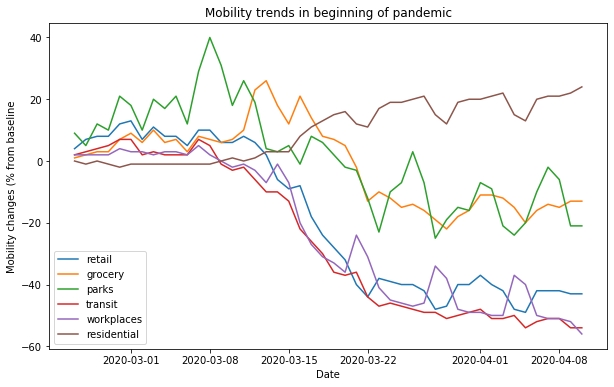

In [26]:
#Make a plot of mobility changes in initial outbreak period
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_outbreak.index, df_outbreak[mobility])
ax.set_title("Mobility trends in beginning of pandemic")
ax.set_xlabel("Date")
ax.set_ylabel("Mobility changes (% from baseline")
ax.legend(["retail", "grocery", "parks", "transit", "workplaces", "residential"])


In [29]:
#granger causality test on whether stringency index contains predictive info on retail mobility
#Important note: there cannot be any nan values or else the function gives error
grangercausalitytests(df_outbreak[['mobility_retail_and_recreation', 'stringency_index']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.2125 , p=0.0000  , df_denom=42, df_num=1
ssr based chi2 test:   chi2=30.2277 , p=0.0000  , df=1
likelihood ratio test: chi2=23.1236 , p=0.0000  , df=1
parameter F test:         F=28.2125 , p=0.0000  , df_denom=42, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2052 , p=0.0001  , df_denom=39, df_num=2
ssr based chi2 test:   chi2=27.5400 , p=0.0000  , df=2
likelihood ratio test: chi2=21.3869 , p=0.0000  , df=2
parameter F test:         F=12.2052 , p=0.0001  , df_denom=39, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.1669  , p=0.0003  , df_denom=36, df_num=3
ssr based chi2 test:   chi2=29.2648 , p=0.0000  , df=3
likelihood ratio test: chi2=22.3229 , p=0.0001  , df=3
parameter F test:         F=8.1669  , p=0.0003  , df_denom=36, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.2258  , p=0.0008  , df_d

{1: ({'ssr_ftest': (28.212523092749162, 3.851070348511486e-06, 42.0, 1),
   'ssr_chi2test': (30.22770331365982, 3.841824869672712e-08, 1),
   'lrtest': (23.123568081289704, 1.5191717164630355e-06, 1),
   'params_ftest': (28.212523092749233, 3.851070348511409e-06, 42.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (12.205207730773616, 7.64941394013926e-05, 39.0, 2),
   'ssr_chi2test': (27.539955905335333, 1.0465851282761722e-06, 2),
   'lrtest': (21.38692527614026, 2.2692805136196722e-05, 2),
   'params_ftest': (12.205207730773564, 7.649413940139503e-05, 39.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.166911442862622, 0.0002820807443889573, 36.0, 3),
   'ssr_chi2test': (29.26476600359106, 1.970127581664562e-06, 3),
   'lrtest': (22.322872259294286, 5.5879799618617635e-05, 3),
   'params_ftest': (8.166911442862608, 0.00028208074438896094, 36.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0.,

In [32]:
#Get location keys for US states. Can be used to make state-by-state comparisons
index_df = pd.read_csv("../data/index.csv")
us_states_df = index_df.loc[(index_df.country_code == "US") & (index_df.aggregation_level==1), :]
state_keys = list(us_states_df["key"])
state_names=list(us_states_df["subregion1_name"])
states = pd.DataFrame({"State": state_names, "Keys": state_keys})
states.head()

,State,Keys
0,Alaska,US_AK
1,Alabama,US_AL
2,Arkansas,US_AR
3,American Samoa,US_AS
4,Arizona,US_AZ
